# Libraries

In [1]:
import pandas as pd
import numpy  as np
import string 
import re
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
# import nltk
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# #from nltk.tokenize.treebank import TreebankWordDetokenizer
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
#from nltk.corpus import stopwords

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import pickle

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import resample
print('Done')


2022-01-12 11:41:09.660232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-12 11:41:09.660248: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Done


# Help functions

## Undersampling

In [2]:
def undersample(df, prop = 2):
    
    # get label 2
    df2 = df[df["label"]==2]
    n2 = df2.shape[0]
    
    # get label 0
    df0= df[df["label"]==0]
    df0 = df0.sample(frac=1)
    
    # sample from label 0
    n0 = round(prop*n2)
    df0_sample = df0.head(n0)
    
    # concatenate
    df = pd.concat([df0_sample,df2], axis = 0)
    df = df.sample(frac=1)
    df.reset_index(inplace = True)
    
    assert(n0==prop*n2)
    return df[["text","score_punctuation", "score_capital_word", "label"]]

## Oversampling

In [3]:
def oversample(df, prop = 0.3 , seed = 123):
    n = df.shape[0]
    n2_new = round(prop*n) 
    
    # get label 2
    df2 = df[df["label"]==2]
    n2 = df2.shape[0]
    n2_resample = n2_new - n2
    if (n2_resample) < 0:
        print(f"WARNING: proportion {prop} already satisfied, DF unchanged")
    
    else : 
        indices = list(range(n2))
    
        # resample from df2
        indices_resample = resample(indices, replace=True, n_samples =n2_resample, random_state=f"{seed}")
        df2_resample = df2.iloc[indices_resample]

        df2_new = pd.concat([df2_resample, df2], axis =0)

        df_new = pd.concat([df2_new, df[df["label"]==0]], axis =0)
        df = df_new
    #assert(df2_new.shape[0]==prop*n)
    df = df.sample(frac=1)
    df.reset_index(inplace = True)
    return df[["text","score_punctuation", "score_capital_word", "label"]]


## Data cleaning and tokenizing function

In [4]:
# # clean each tweet
# def clean_data(data, remove_special_char_2lower_case = True):
    
#     #Removing URLs with a regular expression
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     data = url_pattern.sub(r'', data)

#     # Remove Emails
#     data = re.sub('\S*@\S*\s?', '', data)
   
#     # tokenize + remove scpecial characters + set to lower case
#     if remove_special_char_2lower_case == True:
#         data = text_to_word_sequence(data) 
#     else :
#     # tokenize 
#         data = data.split() 
    
    
#     # Remove stopwords
#     stop_words = set(stopwords.words('english')) 
#     data = [w for w in data if not w in stop_words]         
    
#     # Remove digits
#     data = ' '.join(word for word in data if not word.isdigit())
    
    
#     return text_to_word_sequence(data)

# # clean dataset
# def apply_data_cleaning(X, text, drop_text = False, remove_special_char_2lower_case = True):
#     ln = X.shape[0]
#     sentences = []
#     for i in range(ln):
#         tmp = X.iloc[i][f'{text}']
#         tmp_clean = clean_data(tmp,remove_special_char_2lower_case = f"{remove_special_char_2lower_case}")
#         sentences.append(tmp_clean)
#     X["sentences"] = sentences
#     if drop_text == True:
#         X.drop(columns = f'{text}', inplace = True)
#     return X

In [5]:
def clean_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
   
    # tokenize + remove scpecial characters + set to lower case
    data = text_to_word_sequence(data) 
    
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')) 
    data = [w for w in data if not w in stop_words]         
    
    # Remove digits
    data = ' '.join(word for word in data if not word.isdigit())
    
    
    return text_to_word_sequence(data)

def apply_data_cleaning(X, text, drop_text = False):
    ln = X.shape[0]
    sentences = []
    for i in range(ln):
       # print (f"{i}")
        tmp = X.iloc[i][f'{text}']
        tmp_clean = clean_data(tmp)
        sentences.append(tmp_clean)
    X["sentences"] = sentences
    if drop_text == True:
        X.drop(columns = f'{text}', inplace = True)
    return X

## Help function for Embedding

In [6]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed



# Help function adding features to embedding

In [7]:
def append_features_to_tensor(X_text, X_feature, _max ):

    tmp = np.empty(shape=(X_text.shape[0],X_text.shape[1]+2, X_text.shape[2] ))
    tmp[:,0:X_text.shape[1],:] = X_text

    first_indices = X_text.shape[0] ## # of twitts 
    tmp_punct =  np.zeros(shape = (1,X_text.shape[2]))
    tmp_cap = np.zeros(shape = (1,X_text.shape[2]))

    for i in range(first_indices):
        if X_feature.iloc[i,0] == 1:
            tmp_punct =  tmp_punct*(_max+0.5)

        if X_feature.iloc[i,1] == 1:
            tmp_cap = tmp_cap*(_max+1)   

        tmp[i,200,:] = tmp_punct
        tmp[i,201,:] = tmp_cap

    
    return tmp

# Data

## Load re-labeled data

In [8]:
with open('../raw_data/DF', 'rb') as handle:
    DF = pickle.load(handle)
DF.dropna(inplace = True)

## Undersample

In [9]:
df = undersample(df= DF, prop = 9)
df.shape
df["label"].value_counts()

0    90819
2    10091
Name: label, dtype: int64

## Oversample

In [10]:
# df = oversample(df =df , prop = 0.3 , seed = 123)
# df.shape
# df["label"].value_counts()

## SubSampling 

In [11]:
N =100
df = df.head(N)
df.label.value_counts()

0    89
2    11
Name: label, dtype: int64

# Data split train, test

In [12]:
# Split in X, y
X = df.copy() 
X.drop(columns = "label", inplace = True)
y = df["label"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
assert(len(X_train)==len(y_train))
assert(len(X_test)==len(y_test))
assert(len(X_train)+len(X_test)==X.shape[0])

# Split X into text and features
X_train_text = X_train[["text"]]
X_test_text = X_test[["text"]]

X_train_features = X_train[["score_punctuation", "score_capital_word"]]
X_test_features = X_test[["score_punctuation", "score_capital_word"]]



In [13]:
print(len(y))
print(len(y_train))
print(len(y_test))

100
80
20


In [14]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(100, 3)
(80, 3)
(20, 3)


In [15]:
X_train.head()

,text,score_punctuation,score_capital_word
55,brought tears to 😉,0,0
88,Public enjoy it,0,0
26,Bill Cosby is in prison. But the first real t...,0,0
42,Me: *walks to bus stop after work minding my o...,0,1
69,This dumb bitch reallycompared sheck Wes to r ...,0,0


In [16]:
X_test.head()

,text,score_punctuation,score_capital_word
83,Molestation accused ( ) gets new job in \nW...,0,0
53,Ok I worded that wrong and didn’t mean just n...,0,0
70,Sir Philip Green named as man at centre of 'UK...,0,0
45,Has Foot Ball's Movement Arrived?,0,0
44,Who are you trying to impress today?,0,0


# Clean and tokenize text

In [17]:
# print(X_text.head())
X_train_text = apply_data_cleaning(X = X_train_text, text = "text",drop_text = True)#, remove_special_char_2lower_case = True)
X_test_text = apply_data_cleaning(X = X_test_text, text = "text", drop_text = True)#, remove_special_char_2lower_case = True)

X_train_text = list(X_train_text.sentences)
y_train = np.array(y)

X_test_text = list(X_test_text.sentences)
y_test = np.array(y)



# Embedding TF




In [18]:
#print(list(api.info()['models'].keys()))
ll = ['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300', 
 'word2vec-ruscorpora-300', 
 'word2vec-google-news-300', 
 'glove-wiki-gigaword-50', 
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200', 
 'glove-wiki-gigaword-300', 
 'glove-twitter-25', 
 'glove-twitter-50', 
 'glove-twitter-100', 
 'glove-twitter-200', 
 '__testing_word2vec-matrix-synopsis']
word2vec_transfer = api.load("glove-twitter-50")

In [19]:
# Embed the training and test sentences
X_train_embed_tf = embedding(word2vec_transfer, X_train_text)
X_test_embed_tf = embedding(word2vec_transfer, X_test_text)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed_tf, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed_tf, dtype='float32', padding='post', maxlen=200)

## Pickle and save embedded data 

In [20]:
print(len(y_train))
print(len(y_test))

print(X_train.shape)
print(X_test.shape)

100
100
(80, 3)
(20, 3)


In [27]:
# X_train
with open('../raw_data/X_train_pad', 'wb') as f1:
    pickle.dump(X_train_pad, f1)
    
# X_test
with open('../raw_data/X_test_pad', 'wb') as f1:
    pickle.dump(X_test_pad, f1)   
    

# y_train
with open('../raw_data/y_train', 'wb') as f1:
    pickle.dump(y_train, f1)
    
# y_test2
with open('../raw_data/y_test', 'wb') as f1:
    pickle.dump(y_test, f1)   

# Add features to tensor

In [28]:
X_train_pad_added_features = append_features_to_tensor(X_train_pad, \
                                                       X_feature = X_train_features, \
                                                       _max = X_train_pad.max())

In [29]:
X_test_pad_added_features = append_features_to_tensor(X_test_pad, \
                                                       X_feature = X_test_features, \
                                                       _max = X_test_pad.max())

# Pickle data

# Run model

In [49]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())#, label ="layer1_masking")
    model.add(layers.LSTM(20, activation='tanh'))#, label ="layer2_LSTM")
    model.add(layers.Dense(15, activation='relu'))#, label ="layer3_dense_relu")
    model.add(layers.Dense(1, activation='sigmoid'))#, label ="layer4_dense_sigmoid")

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=["Recall"]) #['recall']) # tp/(tp+fn) metrics=[tf.keras.metrics.Recall()]
    
    return model

model = init_model()


In [54]:
es = EarlyStopping(patience=10, restore_best_weights=True)
#%%time
history = model.fit(X_train_pad, y_train, 
          batch_size = 32,  # low --> optimizes on smaller ss --> faster --> but to generalize 
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )


Epoch 1/100
2/2 [==============================] - 8s 934ms/step - loss: 0.6598 - recall: 0.1250 - val_loss: 0.6096 - val_recall: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 94ms/step - loss: 0.6171 - recall: 0.0000e+00 - val_loss: 0.5886 - val_recall: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 88ms/step - loss: 0.5926 - recall: 0.0000e+00 - val_loss: 0.5730 - val_recall: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 92ms/step - loss: 0.5748 - recall: 0.0000e+00 - val_loss: 0.5583 - val_recall: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 91ms/step - loss: 0.5613 - recall: 0.0000e+00 - val_loss: 0.5537 - val_recall: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 92ms/step - loss: 0.5468 - recall: 0.0000e+00 - val_loss: 0.5473 - val_recall: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 93ms/step - loss: 0.5337 - recall: 0.0000e+00 - val_loss: 0.5397 - val_recall: 0.0000

In [46]:
def plot_loss_recall(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model Recall')
    ax[1].set_ylabel('recall')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

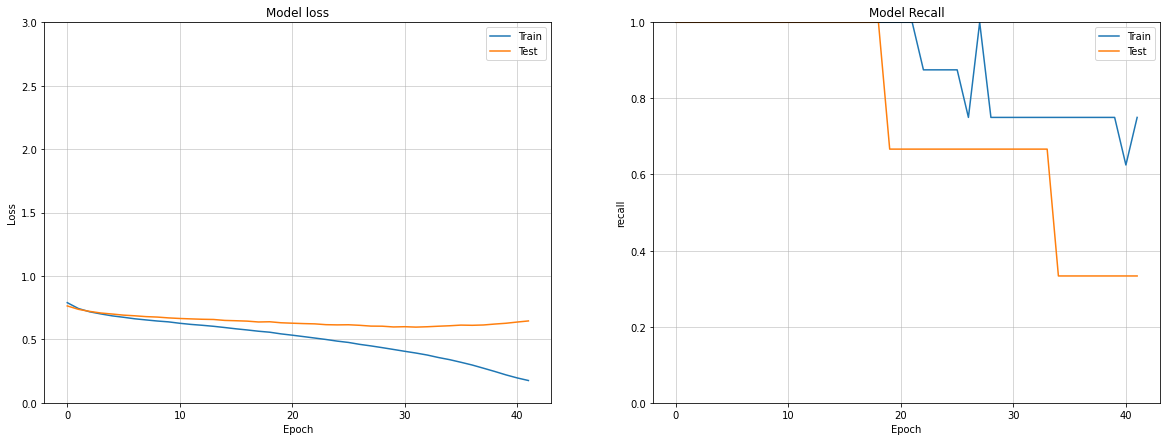

In [48]:
plot_loss_recall(model.history, title=None)

## Select epoch and train

In [ ]:
# Save the model
filepath = './saved_model'
save_model(model, filepath)
model = load_model(filepath, compile = True)

In [51]:
model = model.fit(X_train_pad, y_train, 
          batch_size = 32,  # low --> optimizes on smaller ss --> faster --> but to generalize 
          epochs= 32, #100,
          validation_split=0.3)

Epoch 1/32
2/2 [==============================] - 5s 1s/step - loss: 0.7066 - recall: 0.5000 - val_loss: 0.6738 - val_recall: 0.6667
Epoch 2/32
2/2 [==============================] - 0s 136ms/step - loss: 0.6806 - recall: 0.1250 - val_loss: 0.6635 - val_recall: 0.3333
Epoch 3/32
2/2 [==============================] - 0s 122ms/step - loss: 0.6651 - recall: 0.2500 - val_loss: 0.6550 - val_recall: 0.3333
Epoch 4/32
2/2 [==============================] - 0s 135ms/step - loss: 0.6588 - recall: 0.1250 - val_loss: 0.6509 - val_recall: 0.3333
Epoch 5/32
2/2 [==============================] - 0s 133ms/step - loss: 0.6464 - recall: 0.1250 - val_loss: 0.6449 - val_recall: 0.3333
Epoch 6/32
2/2 [==============================] - 0s 126ms/step - loss: 0.6383 - recall: 0.1250 - val_loss: 0.6380 - val_recall: 0.3333
Epoch 7/32
2/2 [==============================] - 0s 129ms/step - loss: 0.6310 - recall: 0.1250 - val_loss: 0.6336 - val_recall: 0.3333
Epoch 8/32
2/2 [==============================] - 0

# Predict from tweet

In [58]:
model = init_model()
model.fit(X_train_pad, y_train, 
          batch_size = 32,  # low --> optimizes on smaller ss --> faster --> but to generalize 
          epochs=10,
          validation_split=0.3#,
        #  callbacks=[es]
         )

Epoch 1/10
2/2 [==============================] - 4s 820ms/step - loss: 0.6470 - recall: 0.1250 - val_loss: 0.6092 - val_recall: 0.3333
Epoch 2/10
2/2 [==============================] - 0s 89ms/step - loss: 0.6236 - recall: 0.1250 - val_loss: 0.5954 - val_recall: 0.3333
Epoch 3/10
2/2 [==============================] - 0s 95ms/step - loss: 0.6107 - recall: 0.1250 - val_loss: 0.5865 - val_recall: 0.3333
Epoch 4/10
2/2 [==============================] - 0s 93ms/step - loss: 0.6037 - recall: 0.1250 - val_loss: 0.5785 - val_recall: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 99ms/step - loss: 0.5934 - recall: 0.1250 - val_loss: 0.5719 - val_recall: 0.3333
Epoch 6/10
2/2 [==============================] - 0s 93ms/step - loss: 0.5809 - recall: 0.1250 - val_loss: 0.5663 - val_recall: 0.3333
Epoch 7/10
2/2 [==============================] - 0s 102ms/step - loss: 0.5769 - recall: 0.1250 - val_loss: 0.5645 - val_recall: 0.3333
Epoch 8/10
2/2 [==============================] - 0s 

In [67]:
X_test_pad[0:2].shape
#x_test =np.array()

(2, 200, 50)

In [69]:
tweet = X_test_pad[0]
tweet.shape

(200, 50)

In [74]:
tweet_reshape = tweet.reshape((1,tweet.shape[0], tweet.shape[1]))
tweet_reshape.shape

(1, 200, 50)

In [76]:
res = model.predict(tweet_reshape)
res

array([[0.43281996]], dtype=float32)

In [79]:
if res[0][0]< 0.5:
    print("good tweet")
else:
    print("hate tweet")

good tweet


In [80]:
tweet = "I hate it wtf !!!!"
#

## Data prep

In [119]:
# write tweet
tweet = "I hate it wtf !!!!"

In [120]:
## create features 
# add features
def ponctuation_check(tweet):
    score = 0
    for word in tweet.split():
        if word.count('!!!!!') >= 1:
            score += 1
    return score


def capital_word_check(tweet):
    score = 0
    for word in tweet.split():
        if word.isupper():
            score += 1
    return score

In [121]:

score_punctuation = ponctuation_check(tweet)
score_capitalization = capital_word_check(tweet)

In [122]:
# replace emojis with texts


In [123]:
# tokenize
tweet_tokenized = clean_data(tweet)
tweet_tokenized

['hate', 'wtf']

In [124]:
# embed
tweet_emebedded = embed_sentence_with_TF(word2vec_transfer, tweet_tokenized)#[] 

In [125]:
tweet_emebedded_reshape  = tweet_emebedded.reshape((1,tweet_emebedded.shape[0], tweet_emebedded.shape[1]))

In [126]:
tweet_emebedded_reshape.shape

(1, 2, 50)

In [127]:
res = model.predict(tweet_reshape)
res

array([[0.43281996]], dtype=float32)

In [128]:
if res[0][0]< 0.5:
    print("good tweet")
else:
    print("hate tweet")

good tweet


### Prediction time

In [131]:
# write tweet
tweet = "I love deep learning"

score_punctuation = ponctuation_check(tweet)
score_capitalization = capital_word_check(tweet)

tweet_tokenized = clean_data(tweet)
tweet_tokenized

tweet_emebedded = embed_sentence_with_TF(word2vec_transfer, tweet_tokenized)
tweet_emebedded_reshape  = tweet_emebedded.reshape((1,tweet_emebedded.shape[0], tweet_emebedded.shape[1]))

res = model.predict(tweet_reshape)
res

array([[0.43281996]], dtype=float32)

In [132]:
if res[0][0]< 0.5:
    print("good tweet")
else:
    print("hate tweet")

good tweet


# Packaging

In [ ]:
# model save and load

# models.save_model(model, 'my_model')
# loaded_model = models.load_model('my_model')

# filtres scoring
# replace emojis
# score_punctuation
# score_c
